# Avito Demand Prediction Result

In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
# print("Data:\n",os.listdir("../input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

import copy


# Data initialization

The reason we wanted to merge train and testing together (full_data) is this way allows us to only write data transformations for only one time instead of repeating them for train and testing which is prone to errors.

In [2]:
print("Loading data")
train_data = pd.read_csv('train.csv', index_col = "item_id", parse_dates = ["activation_date"])
train_index = train_data.index
train_size = len(train_data)
test_data = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
test_index = test_data.index
y = train_data.deal_probability.copy()


train_data.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*train_data.shape)) 
print('Test shape: {} Rows, {} Columns'.format(*test_data.shape))

print("Combine Train and Test")
full_data = pd.concat([train_data,test_data],axis=0)
del train_data, test_data
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*full_data.shape))

Loading data
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [3]:
full_data.head(5)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
item_id,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0


# Feature Engineering
## Date time features


In [4]:
print("Feature Engineering")
# full_data["price"] = np.log(full_data["price"]+0.001)
# full_data["price"].fillna(-999,inplace=True)
# full_data["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
full_data["weekday"] = full_data['activation_date'].dt.weekday
full_data["woy"] = full_data['activation_date'].dt.week
full_data["dom"] = full_data['activation_date'].dt.day
full_data["doy"] = full_data['activation_date'].dt.dayofyear

num_vars = ['price', 'item_seq_number', 'weekday', 'woy', 'dom', 'doy']

Feature Engineering

Create Time Variables


## Categorical features 
### Label encoding
As mentioned in the presentation, label-encoding is the quickest yet effective way to encode categorical features for decisition tree based models, especially for features with high cardinalities (e.g. postal code)

In [5]:
print("Encode Variables")
cat_vars = ["user_id","region","city","parent_category_name","category_name","user_type", "image_top_1"]
print("Encoding :",cat_vars)
    
    
LBL = preprocessing.LabelEncoder() # sklearn

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_

print ("Label-encoded feaures: %s" % (LE_vars))    
    

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1']
Label Encoding user_id
Label Encoding region
Label Encoding city
Label Encoding parent_category_name
Label Encoding category_name
Label Encoding user_type
Label Encoding image_top_1
Label-encoded feaures: ['user_id_le', 'region_le', 'city_le', 'parent_category_name_le', 'category_name_le', 'user_type_le', 'image_top_1_le']


### Cateogrical feature - one hot encoding (optional)¶

Performing One-hot encoding for this competition is unlikely going to work due to the size of data. However, if we want to use other algorithms such as MLP we'll still have to do it. 

Another tip for OHE is that you don't want to concatenate the converted OHE features with the original dataframe(full_data) becuase it would exponentially enlarge the size of the dataframe. In fact, it's recommended to use scipy.sparse.hstack to concatenate the data which you will see in the following sections.

In fact, LightGBM has a similar but more efficient way as OHE for which you simply need to setup the categorial_feature parameter when constructing LightGBM's data matrix. We will cover it later in this notebook. 


```python
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

```

## Feature interactions 
### Categorical to categorical: combine relative categories

In [6]:
full_data['region_city'] = full_data['region'] + full_data['city']
full_data['combined_category'] = full_data['parent_category_name'] + \
    full_data['category_name']
    
full_data['region_city_combined_category'] = full_data['region_city'] + full_data['combined_category']


full_data['category_image'] = full_data['combined_category'] + \
    full_data['image_top_1'].astype(str)

inter_cat_vars = ['region_city', 'combined_category',
                  'region_city_combined_category', 'category_image']


    
LBL = preprocessing.LabelEncoder()

inter_LE_vars=[]
inter_LE_map=dict()
for cat_var in inter_cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    inter_LE_vars.append(LE_var)
    inter_LE_map[cat_var]=LBL.classes_

print ("Label-encoded feaures: %s" % (inter_LE_vars))    
    

Label Encoding region_city
Label Encoding combined_category
Label Encoding region_city_combined_category
Label Encoding category_image
Label-encoded feaures: ['region_city_le', 'combined_category_le', 'region_city_combined_category_le', 'category_image_le']


### Categorical to categorical: rank of image type count by category

image_top_1 appears to be the most important features but why? One of the guesses is the relativeness to the ads category, which can be represented by the count of ads of each image class (image_top_1) within a category. 

In [7]:
tmp =  full_data.groupby(['category_name','image_top_1']).user_id.count().rename("image_rank_by_category").reset_index()
tmp['image_rank_by_category'] = tmp.groupby('category_name')['image_rank_by_category'].rank(method='dense', ascending=False)
full_data = pd.merge(full_data, tmp, how='left', on =['category_name','image_top_1'])
del tmp
gc.collect()

105

### Categorical to numerical feature

Price is another important feature therefore we may want to create more interactions between price and other categorical features with higher cardinality, e.g. region_city_combined_category, which provices the lowest granularity of categories.

In [8]:
# ## price vars
# tmp = full_data.groupby('region_city_combined_category')['price'].describe().reset_index()
# price_stat_vars = ['region_city_combined_category' + '_' + c for c in tmp.columns[1:]]
# tmp.columns = ['region_city_combined_category'] + price_stat_vars
# full_data = pd.merge(full_data, tmp, how='left', on='region_city_combined_category')

# del tmp
# gc.collect()

In [9]:
## price vars
price_stat_vars = []
for grp_var in inter_cat_vars:
    tmp = full_data.groupby(grp_var)['price'].describe().reset_index()
    price_stat_vars = price_stat_vars + [grp_var + '_price_' + c for c in tmp.columns[1:]]
    tmp.columns = [grp_var] + [grp_var + '_price_' + c for c in tmp.columns[1:]]
    full_data = pd.merge(full_data, tmp, how='left', on=grp_var)
    del tmp
    gc.collect()
print (price_stat_vars)

['region_city_price_count', 'region_city_price_mean', 'region_city_price_std', 'region_city_price_min', 'region_city_price_25%', 'region_city_price_50%', 'region_city_price_75%', 'region_city_price_max', 'combined_category_price_count', 'combined_category_price_mean', 'combined_category_price_std', 'combined_category_price_min', 'combined_category_price_25%', 'combined_category_price_50%', 'combined_category_price_75%', 'combined_category_price_max', 'region_city_combined_category_price_count', 'region_city_combined_category_price_mean', 'region_city_combined_category_price_std', 'region_city_combined_category_price_min', 'region_city_combined_category_price_25%', 'region_city_combined_category_price_50%', 'region_city_combined_category_price_75%', 'region_city_combined_category_price_max', 'category_image_price_count', 'category_image_price_mean', 'category_image_price_std', 'category_image_price_min', 'category_image_price_25%', 'category_image_price_50%', 'category_image_price_75%',

## Image feature 

Again, given that image_top_1 is shown as the most important feature, we may need to dig more to extract more information from the images. The quickest way is to caculate classic image statistics such as dullness, whiteness and so on. You can refer to the Kaggle kernal [Ideas for Image Features and Image Quality](https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality/notebook) for more details.

Another idea is bit more complex - instead of using the image class included in the dataset can we make our own? However, since there are more than 1.5M of images we'll need a very efficient algorithm to do that. Fortunately, [Yolo v3](https://pjreddie.com/darknet/yolo/), a great deep learning framework that allows us to do image segmentation and classification very fact, comes in handy. I've already classified all the images using a pretrained yolo v3 model and saved the results in two CSV files: train_image_class and test_image_class which include 4 columns: image, which is the image file name (please note the suffix .jpg is included), image_class_1 - image_class_3, which are the first three objects identified/ classified from the image. The following code shows how to include them into the training/test data.

Note: if you are interested in knowing how to use Yolo for image processing please refer to the Yolo v3 link above and the details of Yolo will not covered in this course. However, I've included a notebook avito_image_yolo.ipynb as a reference on how to use Yolo to classify images for this competition if you are interested.

In [10]:
#image feature
train_image_class = pd.read_csv(r'train_image_class.csv')
test_image_class = pd.read_csv(r'test_image_class.csv')

train_image_class['image'] = train_image_class['image'].apply(lambda x:x[:-4])

test_image_class['image'] = test_image_class['image'].apply(lambda x:x[:-4])
full_data = pd.merge(full_data, pd.concat([train_image_class,test_image_class],axis=0), how = 'left', on='image')
full_data['image_class_1'] = full_data.image_class.apply(lambda x:str(x).split(',')[0])

del train_image_class, test_image_class
gc.collect()

img_class_vars = ['image_class_1']

    
LBL = preprocessing.LabelEncoder()

img_LE_vars=[]
img_LE_map=dict()
for cat_var in img_class_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    img_LE_vars.append(LE_var)
    img_LE_map[cat_var]=LBL.classes_

print ("Label-encoded feaures: %s" % (img_LE_vars))    
    

Label Encoding image_class_1
Label-encoded feaures: ['image_class_1_le']


In [11]:
tmp =  full_data.groupby(['category_name','image_class_1']).user_id.count().rename("image_class_1_rank_by_category").reset_index()
tmp['image_class_1_rank_by_category'] = tmp.groupby('category_name')['image_class_1_rank_by_category'].rank(method='dense', ascending=False)
full_data = pd.merge(full_data, tmp, how='left', on =['category_name','image_class_1'])
del tmp
gc.collect()

56

## Text features

NLP is a huge topic and there are tons of different ways of processing text features. For this tutorial, we will simply use TF-IDF to process the data, as well as calculating some base text statistics.

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
full_data['text_feat'] = full_data.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
# full_data.drop(["param_1","param_2","param_3"],axis=1,inplace=True)


# Meta Text Features
textfeats = ["description","text_feat", "title"]
for cols in textfeats:
    full_data[cols] = full_data[cols].astype(str) 
    full_data[cols] = full_data[cols].astype(str).fillna('nicapotato') # FILL NA
    full_data[cols] = full_data[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    full_data[cols + '_num_chars'] = full_data[cols].apply(len) # Count number of Characters
    full_data[cols + '_num_words'] = full_data[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    full_data[cols + '_num_unique_words'] = full_data[cols].apply(lambda comment: len(set(w for w in comment.split()))) # set
    full_data[cols + '_words_vs_unique'] = full_data[cols+'_num_unique_words'] / full_data[cols+'_num_words'] * 100 # Count Unique Words

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}

def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            #max_features=7000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])
    
start_vect=time.time()
vectorizer.fit(full_data.loc[:train_size].to_dict('records'))
text_vec_sparse = vectorizer.transform(full_data.to_dict('records'))

text_sparse_vars = vectorizer.get_feature_names()
text_stat_vars = ['description_num_chars',
 'description_num_words',
 'description_num_unique_words',
 'description_words_vs_unique',
 'text_feat_num_chars',
 'text_feat_num_words',
 'text_feat_num_unique_words',
 'text_feat_words_vs_unique',
 'title_num_chars',
 'title_num_words',
 'title_num_unique_words',
 'title_words_vs_unique']

print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60)) # minutes



[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 9.79 Minutes


In [15]:
# Naive numerical features
num_vars = ['price', 'item_seq_number', 'weekday', 'woy', 'dom',
            'image_rank_by_category', 'image_class_1_rank_by_category']

# num_vars = ['price', 'item_seq_number', 'weekday', 'dom',
#             'image_rank_by_category', 'image_class_1_rank_by_category']

LE_vars = [
    'user_id_le',
    'region_le',
    'city_le',
    'parent_category_name_le',
    'category_name_le',
    'user_type_le',
    'image_top_1_le']

# Numerical features
# Please note that we are including categorical-to-cateogrical interactions here(inter_LE_vars). This is because they are
# high cardinality features which would better be used as numerical features.
dense_num_vars = num_vars + text_stat_vars + inter_LE_vars + price_stat_vars

# Encoded Categorical features - will be used by LightGBM later categorical_feature
dense_cat_vars = LE_vars + img_LE_vars
dense_vars = dense_num_vars + dense_cat_vars
full_vars = dense_vars + text_sparse_vars

print("Modeling Stage")
# Combine Dense Features with Sparse Text Bag of Words Features
train_x = csr_matrix(hstack([csr_matrix(full_data[0:train_index.shape[0]][dense_vars].values),
                  text_vec_sparse[0:train_index.shape[0]]]))  # Sparse Matrix
test_x = csr_matrix(hstack([csr_matrix(full_data[train_index.shape[0]:]
                            [dense_vars].values), text_vec_sparse[train_index.shape[0]:]]))

for shape in [train_x, test_x]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(full_vars))
# del full_data
gc.collect()

print("\nModeling Stage")

# Training and Validation Set
"""
Using Randomized train/valid split doesn't seem to generalize LB score, so I will try time cutoff
"""
X_train, X_valid, y_train, y_valid = train_test_split(
    train_x, y, test_size=0.10, random_state=23)

Modeling Stage
1503424 Rows and 1186605 Cols
508438 Rows and 1186605 Cols
Feature Names Length:  1186605

Modeling Stage


# Model tuning

Cross validation or holdout validation?

It really depends. Typicall for time series CV doesn' work very well as in which we could be using "future" data to predict "historical" data. However, emperically it could work well based on many feedbacks from Kaggle and other communities so it's up to you to decide whether to trust it or not. In practice many DS would choose using a holdout dataset that has the same period of time as in the test set but how to choose the "right" size and splitting is really challenging and therefore is the key to build a good ML model for time-series problems. 


## LightGBM tuning
### Manual tuning (greedy search)

* Tune one parameter at a time.
* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.
* Tuning with a larger learning rate 0.1.
* scale_pos_weight needs to be tuned for imbalanced dataset.

In [16]:
import copy
default_lgb_params = {}
default_lgb_params["objective"] = "regression"
default_lgb_params["learning_rate"] = 0.1
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234

params_lgb_space = {}
params_lgb_space['num_leaves'] = [15, 31, 63, 127, 255, 511, 1023]
params_lgb_space['max_depth'] = [15, 31, 63, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]


lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=full_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=full_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False )

greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        model = lgb.train(
            params,
            lgtrain,
            num_boost_round=16000,
            valid_sets=[lgtrain, lgvalid],
            valid_names=['train','valid'],
            early_stopping_rounds=200,
            verbose_eval=500
)
        best_iteration = model.best_iteration
        best_score = model.best_score['valid']['rmse']
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)    

    


 Tuning parameter num_leaves in [15, 31, 63, 127, 255, 511, 1023]

    num_leaves: 15


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.218366	valid's rmse: 0.223488
[1000]	train's rmse: 0.214713	valid's rmse: 0.222253
[1500]	train's rmse: 0.212075	valid's rmse: 0.221707
[2000]	train's rmse: 0.209859	valid's rmse: 0.221368
[2500]	train's rmse: 0.207853	valid's rmse: 0.221113
[3000]	train's rmse: 0.206037	valid's rmse: 0.220973
[3500]	train's rmse: 0.204382	valid's rmse: 0.220847
[4000]	train's rmse: 0.202752	valid's rmse: 0.220764
[4500]	train's rmse: 0.201292	valid's rmse: 0.22076
Early stopping, best iteration is:
[4320]	train's rmse: 0.201804	valid's rmse: 0.220743
, best_score: 0.220743, best_iteration: 4320

    num_leaves: 31


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.212868	valid's rmse: 0.221874
[1000]	train's rmse: 0.207795	valid's rmse: 0.22115
[1500]	train's rmse: 0.203731	valid's rmse: 0.220797
[2000]	train's rmse: 0.200128	valid's rmse: 0.22058
[2500]	train's rmse: 0.196957	valid's rmse: 0.220467
[3000]	train's rmse: 0.194065	valid's rmse: 0.22044
[3500]	train's rmse: 0.191424	valid's rmse: 0.220447
Early stopping, best iteration is:
[3318]	train's rmse: 0.192379	valid's rmse: 0.220426
, best_score: 0.220426, best_iteration: 3318

    num_leaves: 63


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.205877	valid's rmse: 0.220879
[1000]	train's rmse: 0.198072	valid's rmse: 0.220463
[1500]	train's rmse: 0.191657	valid's rmse: 0.220335
Early stopping, best iteration is:
[1482]	train's rmse: 0.19187	valid's rmse: 0.220325
, best_score: 0.220325, best_iteration: 1482

    num_leaves: 127


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.19583	valid's rmse: 0.220197
[1000]	train's rmse: 0.183566	valid's rmse: 0.220175
Early stopping, best iteration is:
[822]	train's rmse: 0.187591	valid's rmse: 0.220133
, best_score: 0.220133, best_iteration: 822

    num_leaves: 255


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.180693	valid's rmse: 0.220369
Early stopping, best iteration is:
[358]	train's rmse: 0.187538	valid's rmse: 0.220235
, best_score: 0.220235, best_iteration: 358

    num_leaves: 511


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	train's rmse: 0.182372	valid's rmse: 0.220146
, best_score: 0.220146, best_iteration: 203

    num_leaves: 1023


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[130]	train's rmse: 0.173397	valid's rmse: 0.220348
, best_score: 0.220348, best_iteration: 130
Best num_leaves is 127 with a score of 0.220133

 Tuning parameter max_depth in [15, 31, 63, -1]

    max_depth: 15


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.200663	valid's rmse: 0.22113
[1000]	train's rmse: 0.19087	valid's rmse: 0.220643
Early stopping, best iteration is:
[1283]	train's rmse: 0.186524	valid's rmse: 0.220579
, best_score: 0.220579, best_iteration: 1283

    max_depth: 31


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.196376	valid's rmse: 0.220427
[1000]	train's rmse: 0.184277	valid's rmse: 0.220288
Early stopping, best iteration is:
[907]	train's rmse: 0.186269	valid's rmse: 0.22024
, best_score: 0.220240, best_iteration: 907

    max_depth: 63


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.195776	valid's rmse: 0.220282
Early stopping, best iteration is:
[702]	train's rmse: 0.190482	valid's rmse: 0.22016
, best_score: 0.220160, best_iteration: 702

    max_depth: -1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.19583	valid's rmse: 0.220197
[1000]	train's rmse: 0.183566	valid's rmse: 0.220175
Early stopping, best iteration is:
[822]	train's rmse: 0.187591	valid's rmse: 0.220133
, best_score: 0.220133, best_iteration: 822
Best max_depth is -1 with a score of 0.220133

 Tuning parameter min_gain_to_split in [0, 0.1, 0.3, 1, 1.5, 2, 3]

    min_gain_to_split: 0


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.19583	valid's rmse: 0.220197
[1000]	train's rmse: 0.183566	valid's rmse: 0.220175
Early stopping, best iteration is:
[822]	train's rmse: 0.187591	valid's rmse: 0.220133
, best_score: 0.220133, best_iteration: 822

    min_gain_to_split: 0.1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.195906	valid's rmse: 0.220448
Early stopping, best iteration is:
[793]	train's rmse: 0.18864	valid's rmse: 0.220378
, best_score: 0.220378, best_iteration: 793

    min_gain_to_split: 0.3


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202719	valid's rmse: 0.220677
Early stopping, best iteration is:
[315]	train's rmse: 0.202719	valid's rmse: 0.220677
, best_score: 0.220677, best_iteration: 315

    min_gain_to_split: 1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[102]	train's rmse: 0.212423	valid's rmse: 0.222498
, best_score: 0.222498, best_iteration: 102

    min_gain_to_split: 1.5


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[83]	train's rmse: 0.214525	valid's rmse: 0.223087
, best_score: 0.223087, best_iteration: 83

    min_gain_to_split: 2


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[73]	train's rmse: 0.215775	valid's rmse: 0.22349
, best_score: 0.223490, best_iteration: 73

    min_gain_to_split: 3


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[61]	train's rmse: 0.217529	valid's rmse: 0.224241
, best_score: 0.224241, best_iteration: 61
Best min_gain_to_split is 0 with a score of 0.220133

 Tuning parameter feature_fraction in [0.1, 0.3, 0.5, 0.7, 0.9]

    feature_fraction: 0.1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.20624	valid's rmse: 0.220425
[1000]	train's rmse: 0.197239	valid's rmse: 0.2197
[1500]	train's rmse: 0.190356	valid's rmse: 0.21958
Early stopping, best iteration is:
[1547]	train's rmse: 0.189796	valid's rmse: 0.219564
, best_score: 0.219564, best_iteration: 1547

    feature_fraction: 0.3


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.201694	valid's rmse: 0.219644
[1000]	train's rmse: 0.191846	valid's rmse: 0.219417
Early stopping, best iteration is:
[1075]	train's rmse: 0.190517	valid's rmse: 0.219392
, best_score: 0.219392, best_iteration: 1075

    feature_fraction: 0.5


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.199104	valid's rmse: 0.219813
Early stopping, best iteration is:
[767]	train's rmse: 0.192953	valid's rmse: 0.219665
, best_score: 0.219665, best_iteration: 767

    feature_fraction: 0.7


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.197249	valid's rmse: 0.220116
Early stopping, best iteration is:
[770]	train's rmse: 0.190698	valid's rmse: 0.220005
, best_score: 0.220005, best_iteration: 770

    feature_fraction: 0.9


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.196232	valid's rmse: 0.220358
Early stopping, best iteration is:
[751]	train's rmse: 0.189807	valid's rmse: 0.220308
, best_score: 0.220308, best_iteration: 751
Best feature_fraction is 0.3 with a score of 0.219392

 Tuning parameter bagging_fraction in [0.2, 0.4, 0.6, 0.8, 1]

    bagging_fraction: 0.2


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.20823	valid's rmse: 0.22312
Early stopping, best iteration is:
[327]	train's rmse: 0.211757	valid's rmse: 0.222761
, best_score: 0.222761, best_iteration: 327

    bagging_fraction: 0.4


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.204306	valid's rmse: 0.220988
Early stopping, best iteration is:
[379]	train's rmse: 0.207259	valid's rmse: 0.220951
, best_score: 0.220951, best_iteration: 379

    bagging_fraction: 0.6


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202625	valid's rmse: 0.220269
Early stopping, best iteration is:
[467]	train's rmse: 0.203424	valid's rmse: 0.220253
, best_score: 0.220253, best_iteration: 467

    bagging_fraction: 0.8


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.20184	valid's rmse: 0.219738
[1000]	train's rmse: 0.191095	valid's rmse: 0.219755
Early stopping, best iteration is:
[864]	train's rmse: 0.193748	valid's rmse: 0.219636
, best_score: 0.219636, best_iteration: 864

    bagging_fraction: 1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.201694	valid's rmse: 0.219644
[1000]	train's rmse: 0.191846	valid's rmse: 0.219417
Early stopping, best iteration is:
[1075]	train's rmse: 0.190517	valid's rmse: 0.219392
, best_score: 0.219392, best_iteration: 1075
Best bagging_fraction is 1 with a score of 0.219392

 Tuning parameter min_sum_hessian_in_leaf in [1, 5, 10, 30, 100]

    min_sum_hessian_in_leaf: 1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.201694	valid's rmse: 0.219644
[1000]	train's rmse: 0.191846	valid's rmse: 0.219417
Early stopping, best iteration is:
[1075]	train's rmse: 0.190517	valid's rmse: 0.219392
, best_score: 0.219392, best_iteration: 1075

    min_sum_hessian_in_leaf: 5


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.201694	valid's rmse: 0.219644
[1000]	train's rmse: 0.191846	valid's rmse: 0.219417
Early stopping, best iteration is:
[1075]	train's rmse: 0.190517	valid's rmse: 0.219392
, best_score: 0.219392, best_iteration: 1075

    min_sum_hessian_in_leaf: 10


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.201694	valid's rmse: 0.219644
[1000]	train's rmse: 0.191846	valid's rmse: 0.219417
Early stopping, best iteration is:
[1075]	train's rmse: 0.190517	valid's rmse: 0.219392
, best_score: 0.219392, best_iteration: 1075

    min_sum_hessian_in_leaf: 30


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202114	valid's rmse: 0.219621
[1000]	train's rmse: 0.192563	valid's rmse: 0.219397
Early stopping, best iteration is:
[861]	train's rmse: 0.194906	valid's rmse: 0.219387
, best_score: 0.219387, best_iteration: 861

    min_sum_hessian_in_leaf: 100


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.203052	valid's rmse: 0.219691
[1000]	train's rmse: 0.194602	valid's rmse: 0.219457
Early stopping, best iteration is:
[863]	train's rmse: 0.196673	valid's rmse: 0.219428
, best_score: 0.219428, best_iteration: 863
Best min_sum_hessian_in_leaf is 30 with a score of 0.219387

 Tuning parameter lambda_l2 in [0, 0.01, 0.1, 1, 10, 100]

    lambda_l2: 0


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202114	valid's rmse: 0.219621
[1000]	train's rmse: 0.192563	valid's rmse: 0.219397
Early stopping, best iteration is:
[861]	train's rmse: 0.194906	valid's rmse: 0.219387
, best_score: 0.219387, best_iteration: 861

    lambda_l2: 0.01


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202139	valid's rmse: 0.219556
[1000]	train's rmse: 0.192753	valid's rmse: 0.219313
Early stopping, best iteration is:
[1099]	train's rmse: 0.19114	valid's rmse: 0.219296
, best_score: 0.219296, best_iteration: 1099

    lambda_l2: 0.1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202145	valid's rmse: 0.219585
[1000]	train's rmse: 0.192694	valid's rmse: 0.219389
Early stopping, best iteration is:
[897]	train's rmse: 0.194447	valid's rmse: 0.219381
, best_score: 0.219381, best_iteration: 897

    lambda_l2: 1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202242	valid's rmse: 0.219621
[1000]	train's rmse: 0.192918	valid's rmse: 0.219356
Early stopping, best iteration is:
[904]	train's rmse: 0.194485	valid's rmse: 0.219324
, best_score: 0.219324, best_iteration: 904

    lambda_l2: 10


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.202841	valid's rmse: 0.219493
[1000]	train's rmse: 0.194094	valid's rmse: 0.219139
[1500]	train's rmse: 0.187106	valid's rmse: 0.219119
Early stopping, best iteration is:
[1325]	train's rmse: 0.189412	valid's rmse: 0.219088
, best_score: 0.219088, best_iteration: 1325

    lambda_l2: 100


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.204968	valid's rmse: 0.219521
[1000]	train's rmse: 0.197843	valid's rmse: 0.219071
[1500]	train's rmse: 0.192285	valid's rmse: 0.218955
Early stopping, best iteration is:
[1415]	train's rmse: 0.193123	valid's rmse: 0.218947
, best_score: 0.218947, best_iteration: 1415
Best lambda_l2 is 100 with a score of 0.218947

 Tuning parameter lambda_l1 in [0, 0.01, 0.1, 1, 10, 100]

    lambda_l1: 0


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.204968	valid's rmse: 0.219521
[1000]	train's rmse: 0.197843	valid's rmse: 0.219071
[1500]	train's rmse: 0.192285	valid's rmse: 0.218955
Early stopping, best iteration is:
[1415]	train's rmse: 0.193123	valid's rmse: 0.218947
, best_score: 0.218947, best_iteration: 1415

    lambda_l1: 0.01


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.204994	valid's rmse: 0.219485
[1000]	train's rmse: 0.197879	valid's rmse: 0.218907
[1500]	train's rmse: 0.192294	valid's rmse: 0.2188
Early stopping, best iteration is:
[1565]	train's rmse: 0.191583	valid's rmse: 0.218788
, best_score: 0.218788, best_iteration: 1565

    lambda_l1: 0.1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.205045	valid's rmse: 0.219588
[1000]	train's rmse: 0.197862	valid's rmse: 0.219063
[1500]	train's rmse: 0.192244	valid's rmse: 0.218888
Early stopping, best iteration is:
[1552]	train's rmse: 0.191683	valid's rmse: 0.218863
, best_score: 0.218863, best_iteration: 1552

    lambda_l1: 1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.205098	valid's rmse: 0.219594
[1000]	train's rmse: 0.197794	valid's rmse: 0.219081
[1500]	train's rmse: 0.19225	valid's rmse: 0.218949
Early stopping, best iteration is:
[1778]	train's rmse: 0.189497	valid's rmse: 0.218924
, best_score: 0.218924, best_iteration: 1778

    lambda_l1: 10


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.206545	valid's rmse: 0.220195
[1000]	train's rmse: 0.200411	valid's rmse: 0.219724
[1500]	train's rmse: 0.195106	valid's rmse: 0.219621
Early stopping, best iteration is:
[1548]	train's rmse: 0.194683	valid's rmse: 0.219612
, best_score: 0.219612, best_iteration: 1548

    lambda_l1: 100


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[500]	train's rmse: 0.216986	valid's rmse: 0.222879
Early stopping, best iteration is:
[476]	train's rmse: 0.216986	valid's rmse: 0.222879
, best_score: 0.222879, best_iteration: 476
Best lambda_l1 is 0.01 with a score of 0.218788

 Best manually tuned parameters: {'objective': 'regression', 'learning_rate': 0.1, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'num_leaves': 127, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62], 'max_depth': -1, 'min_gain_to_split': 0, 'feature_fraction': 0.3, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 30, 'lambda_l2': 100, 'lambda_l1': 0.01}


### Automated tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance. 

Visit https://github.com/fmfn/BayesianOptimization for more details about Bayesian Optimization.

In [20]:
! pip install bayesian-optimization

  Running setup.py bdist_wheel for bayesian-optimization ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f5/ef/5c/9ff1d2d86ad1117bf4cd3f989356ae46fa907014ece63b09dd
Successfully built bayesian-optimization
distributed 1.21.8 requires msgpack, which is not installed.


In [21]:
from bayes_opt import BayesianOptimization


lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=full_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=full_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False )


def lgb_evaluate(
                 num_leaves,
                 max_depth,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 lambda_l2,
                 lambda_l1
                 ):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.1
    params['seed'] = 1234
    params['max_bin'] = 127
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1   
    params["metric"] = 'rmse'

    model = lgb.train(
                params,
                lgtrain,
                num_boost_round=16000,
                valid_sets=[lgtrain, lgvalid],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=False
    )
    best_iteration = model.best_iteration
    best_score = model.best_score['valid']['rmse']
    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return -best_score


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {
#                                  'max_bin': (100, 300),
                              'num_leaves': (63, 511),
                              'max_depth': (31, 127),
                              'min_sum_hessian_in_leaf': (10, 100),
                              'min_gain_to_split': (0,0.5),
                              'feature_fraction': (0.2, 0.5),
                              'bagging_fraction': (0.8,1),
                              'lambda_l2': (50,500),
                              'lambda_l1': (0.01,1)
                             }
                            )

lgb_BO.maximize(init_points=5, n_iter=40)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


, best_score: 0.220549, best_iteration: 266
    1 | 11m21s |   -0.22055 |             0.8127 |             0.4956 |      0.9020 |    470.3214 |    104.7054 |              0.0716 |                   52.8810 |     450.4950 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221477, best_iteration: 2018
    2 | 07m13s |   -0.22148 |             0.8160 |             0.3592 |      0.9025 |    384.1703 |    110.5723 |              0.4279 |                   64.0025 |     414.2229 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220867, best_iteration: 390
    3 | 06m44s |   -0.22087 |             0.8192 |             0.4812 |      0.7870 |    467.6335 |    126.8680 |              0.2220 |                   11.9631 |     224.0321 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220316, best_iteration: 1014
    4 | 07m11s |   -0.22032 |             0.9430 |             0.4156 |      0.0578 |    294.0115 |    115.3632 |              0.2260 |                   71.9364 |     324.9786 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220528, best_iteration: 1192
    5 | 12m31s |   -0.22053 |             0.8629 |             0.4812 |      0.6738 |    446.7318 |    112.9742 |              0.0800 |                   29.2274 |      89.4569 | 
Bayesian Optimization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219362, best_iteration: 379
    6 | 12m40s |   -0.21936 |             0.8504 |             0.3816 |      0.2032 |     55.2586 |     31.0165 |              0.0479 |                   10.1170 |     290.1451 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220487, best_iteration: 1874
    7 | 08m48s |   -0.22049 |             0.9715 |             0.3463 |      0.5165 |     50.3199 |    124.8554 |              0.2043 |                   94.6116 |      68.6755 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221805, best_iteration: 472
    8 | 03m07s |   -0.22181 |             0.9857 |             0.3673 |      0.9544 |    496.9206 |     32.0921 |              0.3950 |                   98.5193 |     247.9477 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221119, best_iteration: 2621
    9 | 07m02s |   -0.22112 |             0.9017 |             0.2174 |      0.7671 |     52.0865 |    125.0272 |              0.4201 |                   91.9400 |     500.6614 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220019, best_iteration: 329
   10 | 12m43s |   -0.22002 |             0.8303 |             0.3966 |      0.4677 |    434.2256 |     32.4859 |              0.0798 |                   10.1230 |     507.7512 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221869, best_iteration: 1800
   11 | 05m51s |   -0.22187 |             0.8701 |             0.2643 |      0.1545 |    232.2922 |     34.1116 |              0.4542 |                   11.5354 |      63.2936 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219081, best_iteration: 496
   12 | 18m57s |   -0.21908 |             0.9893 |             0.2456 |      0.1134 |     50.9963 |    124.2290 |              0.0691 |                   10.4406 |     348.5623 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221129, best_iteration: 1437
   13 | 07m53s |   -0.22113 |             0.8493 |             0.2227 |      0.7432 |    486.5959 |     31.9920 |              0.2622 |                   97.4863 |     507.6785 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220287, best_iteration: 512
   14 | 06m04s |   -0.22029 |             0.8488 |             0.4417 |      0.2985 |     75.0725 |     41.3202 |              0.3551 |                   10.8023 |     507.7270 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220304, best_iteration: 1359
   15 | 06m30s |   -0.22030 |             0.9805 |             0.4267 |      0.0910 |     54.2026 |     38.3483 |              0.2522 |                   99.1469 |     242.7982 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024559]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220548, best_iteration: 1441
   16 | 11m37s |   -0.22055 |             0.8874 |             0.2971 |      0.1141 |    487.6188 |    120.1204 |              0.1516 |                   98.9353 |      74.0418 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220396, best_iteration: 1881
   17 | 08m15s |   -0.22040 |             0.9813 |             0.3039 |      0.9640 |    211.4223 |    126.5629 |              0.1659 |                   96.2306 |     142.8801 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221404, best_iteration: 1796
   18 | 05m20s |   -0.22140 |             0.9455 |             0.3575 |      0.0472 |    499.4937 |     40.8212 |              0.3859 |                   10.3154 |     503.7231 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.66833951e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219983, best_iteration: 396
   19 | 08m35s |   -0.21998 |             0.8951 |             0.4130 |      0.7162 |    228.9328 |    126.2740 |              0.1755 |                   13.8774 |     509.3784 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219808, best_iteration: 1363
   20 | 13m54s |   -0.21981 |             0.9017 |             0.3739 |      0.1145 |     51.1314 |    121.0305 |              0.1480 |                   11.1860 |      74.7979 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.78162803e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219806, best_iteration: 329
   21 | 13m52s |   -0.21981 |             0.8578 |             0.4320 |      0.9667 |    184.1661 |     33.5416 |              0.0483 |                   20.7563 |     395.4733 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219378, best_iteration: 604
   22 | 15m15s |   -0.21938 |             0.8781 |             0.3219 |      0.2972 |    157.2228 |    123.9400 |              0.0065 |                   10.2614 |     236.0005 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.221220, best_iteration: 1757
   23 | 07m16s |   -0.22122 |             0.8623 |             0.3337 |      0.4149 |    483.7527 |    121.1248 |              0.3541 |                   95.7726 |     510.8676 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220076, best_iteration: 477
   24 | 12m25s |   -0.22008 |             0.8487 |             0.4765 |      0.2100 |    279.0076 |     33.4543 |              0.0070 |                   69.3575 |     218.4846 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219779, best_iteration: 359
   25 | 10m49s |   -0.21978 |             0.8226 |             0.4558 |      0.8680 |     52.7355 |    123.4790 |              0.0324 |                   52.1393 |     253.5109 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219240, best_iteration: 2527
   26 | 16m39s |   -0.21924 |             0.9449 |             0.2758 |      0.2647 |     52.8120 |     32.8887 |              0.0222 |                   19.6385 |      63.5390 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219828, best_iteration: 296
   27 | 10m15s |   -0.21983 |             0.8167 |             0.3725 |      0.9849 |     59.2854 |    122.4640 |              0.1480 |                   19.0388 |     508.5329 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219456, best_iteration: 1109
   28 | 16m42s |   -0.21946 |             0.9507 |             0.2968 |      0.0209 |    366.8998 |    124.6407 |              0.0140 |                   56.8309 |     138.1462 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219104, best_iteration: 988
   29 | 23m56s |   -0.21910 |             0.9819 |             0.2083 |      0.8773 |    302.4467 |    126.1533 |              0.0263 |                   18.3231 |     234.0512 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220342, best_iteration: 2030
   30 | 09m33s |   -0.22034 |             0.9909 |             0.2489 |      0.9648 |     52.9572 |     32.7258 |              0.1420 |                   95.9123 |      67.8069 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categori

, best_score: 0.219512, best_iteration: 558
   31 | 16m01s |   -0.21951 |             0.9181 |             0.4153 |      0.8469 |    210.3790 |     84.3019 |              0.0032 |                   10.3981 |     281.6228 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219869, best_iteration: 304
   32 | 15m53s |   -0.21987 |             0.9067 |             0.4704 |      0.0687 |    435.2569 |    126.5394 |              0.0137 |                   16.0120 |     506.6412 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.26934113e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/ana

, best_score: 0.219774, best_iteration: 520
   33 | 10m56s |   -0.21977 |             0.8060 |             0.4447 |      0.0714 |     52.1567 |     33.5856 |              0.1261 |                   17.6852 |     166.8124 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010505]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219267, best_iteration: 381
   34 | 15m15s |   -0.21927 |             0.8340 |             0.3296 |      0.4858 |    111.8080 |    122.4734 |              0.0184 |                   15.2238 |     394.9034 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

, best_score: 0.219364, best_iteration: 679
   35 | 17m42s |   -0.21936 |             0.9976 |             0.4678 |      0.4291 |    205.3765 |    125.8171 |              0.0143 |                   10.2976 |     264.9241 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219344, best_iteration: 382
   36 | 15m50s |   -0.21934 |             0.9826 |             0.2377 |      0.2930 |     61.4174 |     66.2258 |              0.0764 |                   49.8074 |     378.9378 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

, best_score: 0.219416, best_iteration: 521
   37 | 19m30s |   -0.21942 |             0.9400 |             0.2192 |      0.2329 |    286.0682 |     34.6150 |              0.0642 |                   14.3891 |     509.0109 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219658, best_iteration: 681
   38 | 15m37s |   -0.21966 |             0.9648 |             0.4862 |      0.2295 |    300.7242 |    121.6047 |              0.0030 |                   14.5480 |     209.9852 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00031862]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anacond

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219334, best_iteration: 986
   39 | 19m18s |   -0.21933 |             0.9559 |             0.2608 |      0.9009 |    407.2740 |    126.1121 |              0.0139 |                   81.2243 |     202.8418 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0002522]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219719, best_iteration: 583
   40 | 12m02s |   -0.21972 |             0.9634 |             0.2002 |      0.9946 |    132.0562 |     33.9942 |              0.0993 |                   41.5070 |     321.1593 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00031806]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020217]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances t

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

, best_score: 0.219872, best_iteration: 2157
   41 | 18m55s |   -0.21987 |             0.9279 |             0.2131 |      0.6796 |    413.8570 |     42.0991 |              0.0601 |                   98.5033 |      67.2160 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.220078, best_iteration: 1375
   42 | 14m09s |   -0.22008 |             0.9226 |             0.4314 |      0.9125 |    362.2915 |    120.1438 |              0.0059 |                   96.4323 |      86.0339 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00022103]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

, best_score: 0.220662, best_iteration: 1592
   43 | 05m37s |   -0.22066 |             0.9707 |             0.2228 |      0.7900 |     51.1829 |     54.5356 |              0.3496 |                   13.5935 |     379.9745 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categori

, best_score: 0.219620, best_iteration: 294
   44 | 16m22s |   -0.21962 |             0.8873 |             0.3584 |      0.5761 |    140.9047 |     34.1029 |              0.0330 |                   93.2943 |     503.9445 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: P

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


, best_score: 0.219806, best_iteration: 1797
   45 | 15m15s |   -0.21981 |             0.9491 |             0.3631 |      0.6039 |    495.0335 |     31.2484 |              0.0273 |                   23.8080 |      72.1456 | 


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00096653]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [22]:
# gc.collect()

lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.to_csv("tuned_lgb_parameters.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
6,0.989277,0.245615,0.113363,50.996279,124.229028,0.069132,10.440561,348.562256,-0.219081
23,0.981899,0.208317,0.877309,302.446719,126.153345,0.026259,18.323104,234.051229,-0.219104
20,0.944921,0.275816,0.264654,52.811975,32.888707,0.022195,19.638475,63.538988,-0.219240
28,0.833999,0.329650,0.485776,111.808027,122.473415,0.018438,15.223762,394.903360,-0.219267
33,0.955892,0.260775,0.900863,407.274048,126.112095,0.013883,81.224314,202.841831,-0.219334


### Validation with smaller learning rate

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.019, 'num_leaves': 348, 'max_depth': 124, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.06913176483066708, 'feature_fraction': 0.24561501004061176, 'bagging_fraction': 0.9892772415845309, 'bagging_freq': 1, 'lambda_l2': 50.99627892868648, 'lambda_l1': 0.11336258040795562}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.21912	valid's rmse: 0.224023
[400]	train's rmse: 0.212827	valid's rmse: 0.22133
[600]	train's rmse: 0.208777	valid's rmse: 0.220066
[800]	train's rmse: 0.20592	valid's rmse: 0.219482
[1000]	train's rmse: 0.203475	valid's rmse: 0.219085
[1200]	train's rmse: 0.201417	valid's rmse: 0.218768
[1400]	train's rmse: 0.199578	valid's rmse: 0.218562
[1600]	train's rmse: 0.19808	valid's rmse: 0.218406
[1800]	train's rmse: 0.196691	valid's rmse: 0.21831
[2000]	train's rmse: 0.195501	valid's rmse: 0.218229
[2200]	train's rmse: 0.194389	valid's rmse: 0.218179
[2400]	train's rmse: 0.193338	valid's rmse: 0.218142
[2600]	train's rmse: 0.192519	valid's rmse: 0.218126
[2800]	train's rmse: 0.191777	valid's rmse: 0.218111
[3000]	train's rmse: 0.191156	valid's rmse: 0.218103
[3200]	train's rmse: 0.190633	valid's rmse: 0.218101
Early stopping, best iteration is:
[3179]	train's rmse: 0.190684	valid's rmse: 0.218099
Model Eval

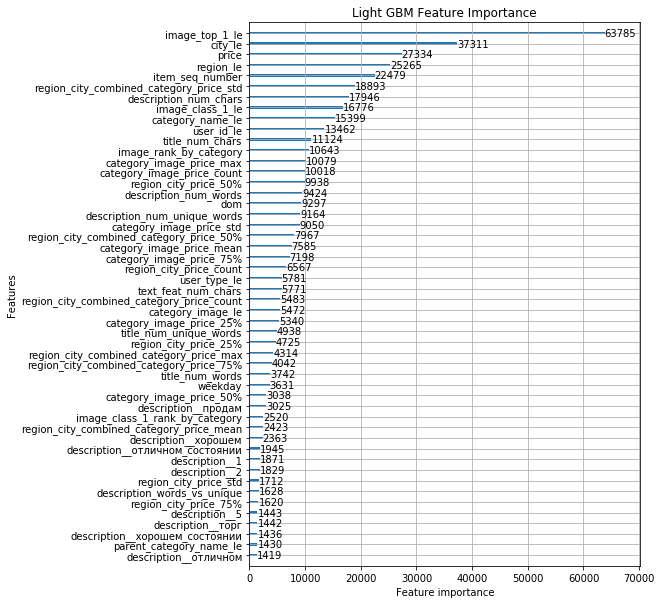

In [23]:
params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'regression'
best_lgb_params["metric"] = 'rmse'
best_lgb_params['learning_rate'] = 0.019 # Smaller learning rate

best_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_params['max_depth'] = int(params['max_depth'])    
best_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = params['feature_fraction']
best_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_params['bagging_freq'] = 1
best_lgb_params['lambda_l2'] = params['lambda_l2']
best_lgb_params['lambda_l1'] = params['lambda_l1']

print (best_lgb_params)

lgb_clf = lgb.train(
    best_lgb_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))


### Retrain the model with smaller learning rate 

In [43]:
modelstart = time.time()

# original from instr
# best_num_boost_round = int(lgb_model.best_iteration*1.05)
# original from instr
# lgb_model = lgb.train(
#     lgbm_params,
#     lgb.Dataset(train_x, y,
#                 feature_name=full_vars,
#                 categorical_feature=dense_cat_vars),
#     num_boost_round=best_num_boost_round
# )
# best_num_boost_round = int(lgb_model.best_iteration*1.05)


# modified by me
best_num_boost_round = int(lgb_clf.best_iteration*1.05)
# modified by me
lgb_model = lgb.train(
    best_lgb_params,
    lgb.Dataset(train_x, y,
                feature_name=full_vars,
                categorical_feature=dense_cat_vars),
    num_boost_round=best_num_boost_round
)

# best_num_boost_round = int(lgb_model.best_iteration*1.05)

lgbpred = lgb_model.predict(test_x)
lgbsub = pd.DataFrame(lgbpred, columns=["deal_probability"], index=test_index)
lgbsub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
lgbsub.to_csv("sub_tuned_lgb.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Model Runtime: 98.03 Minutes
Notebook Runtime: 1550.61 Minutes


In [64]:
best_num_boost_round = int(lgb_clf.best_iteration*1.05)
best_num_boost_round

3337

In [65]:
lgb_model.current_iteration()

3337

In [66]:
best_num_boost_round

3337

## XGBoost (optional)

The following codes are optional as they may take longer time to run. Basically the process is much similar as what's covered above for LightGBM.

### Manual tuning (greedy search)

* Tune one parameter at a time.
* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.

In [ ]:
metric = 'rmse'

default_xgb_params = {}
default_xgb_params["objective"] = "reg:linear"
default_xgb_params["eta"] = 0.15
default_xgb_params["seed"] = 1234
default_xgb_params["metric"] = metric

params_xgb_space = {}
params_xgb_space['max_depth'] = [4,5,6,7,8,9,10]
params_xgb_space['gamma'] = [0, 0.5, 1, 1.5, 2]
params_xgb_space['colsample_bytree'] = [0.1, 0.3,0.5, 0.7,  0.9, 1]
params_xgb_space['subsample'] = [ 0.2, 0.4, 0.6, 0.8, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]

best_xgb_params = copy.copy(default_xgb_params)

greater_is_better = False
xgtrain = xgb.DMatrix(X_train, y_train)
xgvalid = xgb.DMatrix(X_valid, y_valid)

watchlist  = [ (xgtrain,'train'),(xgvalid,'valid')]

for p in params_xgb_space:
    print ("Tuning parameter %s in %s \n" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('    %s: %s' % (p, v), end="\n")
        params[p] = v
        model = xgb.train(best_xgb_params, 
                      xgtrain, 
                      num_boost_round=100000,
                      evals=watchlist,
                      early_stopping_rounds=50,
                      verbose_eval=50)    
        best_iteration = model.best_iteration
        best_score = model.best_score
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))
    

### Automated tuning

In [ ]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'reg:linear'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['seed'] = 1234    


    model = xgb.train(params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=False)    
    best_iteration = model.best_iteration
    best_score = model.best_score

    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return -best_score


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (5, 11),
                              'min_child_weight': (0, 200),
                              'colsample_bytree': (0.2, 1),
                              'subsample': (0.7, 1),
                              'gamma': (0, 3)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=35)

In [ ]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.to_csv("tuned_xgb_parameters.csv", index=False)
xgb_BO_scores.head()

In [ ]:
sns.pairplot(xgb_BO_scores)

### Validation with smaller learning rate

In [ ]:
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'reg:linear'
best_xgb_params['eta'] = 0.019  # Smaller learning rate

best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = int(best_xgb_params['min_child_weight'])
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['seed'] = 1234

best_xgb_params

print (best_xgb_params)

model = xgb.train(best_xgb_params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=50)    
best_xgb_iteration = model.best_iteration
best_xgb_score = model.best_score
print ('best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))



### Retrain the model and create submission

In [ ]:
model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_xgb_iteration)    



xgbpred = model.predict(xgb.DMatrix(test_x))
xgbsub = pd.DataFrame(xgbpred, columns=["deal_probability"], index=test_index)
xgbsub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
xgbsub.to_csv("sub_tuned_xgb.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))

## Ensemble XGBoost and  LightGBM
Let's create a submission by simply averaging predictions of XGBoost model and LightGBM model and see how that performs 

In [ ]:
blend_sub = pd.DataFrame(xgbpred*0.5 + lgbpred*0.5, 
                         columns=["deal_probability"], index=test_index)
blend_sub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
blend_sub.to_csv("sub_tuned_xgblgb_blend.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))

# Model Stacking

1. We'll leverage the tuned parameter sets to train 3 XGBoost models and 3 LightGBM models for level 1.
2. The outputs of level models should consist of 6 features. 
3. We'll train a MLP model using these 6 features only
4. We'll train another LightGBM using these 6 features plus original features
5. The outputs from the two level 2 models can be combined as the final submission

## Stacking Functions

In [44]:
from sklearn.model_selection import StratifiedKFold, KFold 
import copy
def xgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, missing=None):

    skf = KFold(n_splits=kfolds,random_state=1234)
    skf_ids = list(skf.split(train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros ((kfolds,len(rgr_params)))

    print  ("Start stacking.")
    for j, params in enumerate(rgr_params):
        num_boost_round = copy.deepcopy(params['num_boost_round'])
        print ("Stacking model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            
            
            if early_stopping_rounds==0:
                model = xgb.train(params,
                                    xgb.DMatrix(train_x_fold, 
                                                label=train_y_fold.reshape(train_y_fold.shape[0],1), 
                                                missing=missing),
                                    num_boost_round=num_boost_round
                                )
                val_y_predict_fold = model.predict(xgb.DMatrix(val_x_fold,missing=missing))

                score = np.sqrt(metrics.mean_squared_error(val_y_fold,val_y_predict_fold))
                print ("Score: ", score)
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(xgb.DMatrix(test_x,missing=missing))
                print (time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores    


def lgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, early_stopping_rounds=0, missing=None):

    skf = KFold(n_splits=kfolds,random_state=1234)
    skf_ids = list(skf.split(train_y))


    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros ((kfolds,len(rgr_params)))

    print  ("Start stacking.")
    for j, params in enumerate(rgr_params):
        num_boost_round = copy.deepcopy(params['num_boost_round'])
        print ("Stacking model",j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(skf_ids):
            start = time.time()
            print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print (i, params)
            
            
            if early_stopping_rounds==0:
                model = lgb.train(params,
                                    lgb.Dataset(train_x_fold, 
                                                train_y_fold,
                                                feature_name=full_vars,
                                                categorical_feature = dense_cat_vars),
                                  num_boost_round=num_boost_round
                                )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(metrics.mean_squared_error(val_y_fold,val_y_predict_fold))
                print ("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i,j]=score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print ("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores    

## Contruct Level 1 LightGBM models

In [57]:
# best_lgb_iteration = int(lgb_model.current_iteration()*1.05)
# best_lgb_iteration

3503

In [69]:
# Using the best iteration from previous step
best_lgb_iteration = int(lgb_model.current_iteration()*1.05)

# Contruct a number of LightGBM models
lgb_params = []

n_models = 3

for i in range(n_models):
    params = dict()
    params['num_leaves'] = int(lgb_BO_scores['num_leaves'][i])
    params['max_depth'] = int(lgb_BO_scores['max_depth'][i])
    params['min_sum_hessian_in_leaf'] = int(
        lgb_BO_scores['min_sum_hessian_in_leaf'][i])
    params['min_gain_to_split'] = lgb_BO_scores['min_gain_to_split'][i]
    params['feature_fraction'] = lgb_BO_scores['feature_fraction'][i]
    params['bagging_fraction'] = lgb_BO_scores['bagging_fraction'][i]
    params['bagging_freq'] = 1
    params['lambda_l2'] = lgb_BO_scores['lambda_l2'][i]
    params['lambda_l1'] = lgb_BO_scores['lambda_l1'][i]

    params['objective'] = 'regression'
    params['learning_rate'] = 0.019
    params['metric'] = 'rmse'
    params['num_boost_round'] = best_lgb_iteration
    params['seed'] = 1234
    lgb_params.append(params)



print(lgb_params)

[{'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}, {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}, {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.92059

In [70]:
best_lgb_iteration

3503

In [71]:
# Outputs from level 1 LightGBM models
train_blend_x_lgb, test_blend_x_lgb, blend_scores_lgb = \
        lgb_rgr_stack(lgb_params, train_x, y, test_x, 5, early_stopping_rounds=0, missing=None) # 3 个 model, 5 个 fold for stacking
    
# Save outputs for future stacking    
train_blend_x_lgb.tofile('train_blend_x_lgb.dat')
test_blend_x_lgb.tofile('test_blend_x_lgb.dat')    

Start stacking.
Stacking model 1 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}
Model 1 fold 1
0 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Score for Model 1 fold 1: 0.218099 
Model 1 fold 1 finished in 2492 seconds.
Model 1 fold 2
1 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 1 fold 2: 0.218328 
Model 1 fold 2 finished in 2483 seconds.
Model 1 fold 3
2 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 1 fold 3: 0.217989 
Model 1 fold 3 finished in 2405 seconds.
Model 1 fold 4
3 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 1 fold 4: 0.218300 
Model 1 fold 4 finished in 2427 seconds.
Model 1 fold 5
4 {'num_leaves': 290, 'max_depth': 31, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.047867688172657186, 'feature_fraction': 0.3815900701247502, 'bagging_fraction': 0.8503804200210768, 'bagging_freq': 1, 'lambda_l2': 55.25863750317702, 'lambda_l1': 0.20322990336464375, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 1 fold 5: 0.218086 
Model 1 fold 5 finished in 2407 seconds.
Score for model 1 is 0.218160
Stacking model 2 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}
Model 2 fold 1
0 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Score for Model 2 fold 1: 0.219440 
Model 2 fold 1 finished in 1851 seconds.
Model 2 fold 2
1 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 2 fold 2: 0.219695 
Model 2 fold 2 finished in 1812 seconds.
Model 2 fold 3
2 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 2 fold 3: 0.219221 
Model 2 fold 3 finished in 1740 seconds.
Model 2 fold 4
3 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 2 fold 4: 0.219576 
Model 2 fold 4 finished in 1835 seconds.
Model 2 fold 5
4 {'num_leaves': 68, 'max_depth': 124, 'min_sum_hessian_in_leaf': 94, 'min_gain_to_split': 0.20428098588525367, 'feature_fraction': 0.34631164779156065, 'bagging_fraction': 0.97153826041398, 'bagging_freq': 1, 'lambda_l2': 50.31992220173012, 'lambda_l1': 0.5165054672428128, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 2 fold 5: 0.219461 
Model 2 fold 5 finished in 1788 seconds.
Score for model 2 is 0.219478
Stacking model 3 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}
Model 3 fold 1
0 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'num_boost_round': 3503, 'seed': 1234}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Score for Model 3 fold 1: 0.220629 
Model 3 fold 1 finished in 791 seconds.
Model 3 fold 2
1 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 3 fold 2: 0.220858 
Model 3 fold 2 finished in 800 seconds.
Model 3 fold 3
2 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 3 fold 3: 0.220470 
Model 3 fold 3 finished in 790 seconds.
Model 3 fold 4
3 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 3 fold 4: 0.220784 
Model 3 fold 4 finished in 807 seconds.
Model 3 fold 5
4 {'num_leaves': 247, 'max_depth': 32, 'min_sum_hessian_in_leaf': 98, 'min_gain_to_split': 0.39501247787694205, 'feature_fraction': 0.36732245951466636, 'bagging_fraction': 0.9857043684558926, 'bagging_freq': 1, 'lambda_l2': 496.920598600876, 'lambda_l1': 0.9544082825898822, 'objective': 'regression', 'learning_rate': 0.019, 'metric': 'rmse', 'seed': 1234, 'verbose': 1, 'categorical_column': [55, 56, 57, 58, 59, 60, 61, 62]}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Score for Model 3 fold 5: 0.220664 
Model 3 fold 5 finished in 796 seconds.
Score for model 3 is 0.220681


## Create submissions based on Level 1 models

### 1. Blended predictions from a single Level 1 model
Keep in mind that the outputs of each level one model are in fact predictions of training data and testing data. In particular, each column of "test_blend_x_lgb" is sort of blended predictions of test data and therefore can be used as a submission.

In [72]:
# Check model scores
print (np.array(blend_scores_lgb).mean(axis=1))

[0.21938931 0.2196269  0.21922636 0.21955333 0.21940341]


Let's create a submission from the first model's predictions:

In [73]:
pred = test_blend_x_lgb[:,0]

sub = pd.DataFrame(pred, columns=["deal_probability"], index=test_index)
sub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
sub.to_csv("sub_tuned_lgb_model1_blended.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))    

Model Runtime: 1095.06 Minutes
Notebook Runtime: 2547.64 Minutes


### 2. Blended predictions from all level 1 models

We can then create a submission by simply averaging all level models' predictions:

In [74]:
pred = test_blend_x_lgb.mean(axis=1) # 三列平均值

sub = pd.DataFrame(pred, columns=["deal_probability"], index=test_index)
sub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
sub.to_csv("sub_tuned_lgb_all_blended.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))    

Model Runtime: 1095.24 Minutes
Notebook Runtime: 2547.83 Minutes


### 3. Model stacking

Now let's stack level 1 models by using a level 2 model. First, let's try Linear Regression with ridge regularization, using purely outputs from level 1 models.

We need to create a function for simple parameter tuning as comprehensive tuning is not necessary for level 2 models.

In [75]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = 'neg_mean_squared_error',
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

#### Level 2 models - Linear Regression with level 1 outputs

In [76]:
param_grid = {
              "alpha":[0.001,0.01,0.1,1,10,30,100]
              }
model = search_model(train_blend_x_lgb
                                         , y
                                         , Ridge()
                                         , param_grid
                                         , n_jobs=-1
                                         , cv=5
                                         , refit=True)   

print ("best subsample:", model.best_params_)


pred_ridge = model.predict(test_blend_x_lgb)

sub = pd.DataFrame(pred_ridge,columns=["deal_probability"],index=test_index)
sub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
sub.to_csv("sub_l1_lgb_l2_lr.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))



Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] alpha=0.001 .....................................................
[CV] .......... alpha=0.001, score=-0.04753281524957606, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.047631149817167866, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.047484183863935395, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.047621092692769006, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.047520201372729706, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ............ alpha=0.01, score=-0.0475328152690914, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ........... 

[Parallel(n_jobs=-1)]: Done   8 out of  35 | elapsed:   10.1s remaining:   34.2s


[CV] .......... alpha=0.01, score=-0.047621092115501376, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.047520201729292784, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ........... alpha=0.1, score=-0.047532815481861765, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ........... alpha=0.1, score=-0.047631155766052924, total=   0.3s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:   14.3s remaining:   27.5s


[CV] ............ alpha=0.1, score=-0.04748418005689353, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.04762108636228792, total=   0.3s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.04752020531174064, total=   0.3s
[CV] alpha=1 .........................................................
[CV] ............. alpha=1, score=-0.047532819362766154, total=   0.3s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:   18.5s remaining:   22.0s


[CV] ............. alpha=1, score=-0.047631211431375046, total=   0.2s
[CV] alpha=1 .........................................................
[CV] .............. alpha=1, score=-0.04748414730330514, total=   0.2s
[CV] alpha=1 .........................................................
[CV] .............. alpha=1, score=-0.04762103076741013, total=   0.2s
[CV] alpha=1 .........................................................
[CV] ............. alpha=1, score=-0.047520242809630915, total=   0.2s


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:   22.3s remaining:   16.7s


[CV] alpha=10 ........................................................
[CV] ............ alpha=10, score=-0.047533025327142285, total=   0.2s
[CV] alpha=10 ........................................................
[CV] ............ alpha=10, score=-0.047631917533501475, total=   0.2s
[CV] alpha=10 ........................................................
[CV] ............. alpha=10, score=-0.04748399527853149, total=   0.2s
[CV] alpha=10 ........................................................
[CV] ............. alpha=10, score=-0.04762065984458807, total=   0.2s


[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:   26.4s remaining:   12.1s


[CV] alpha=10 ........................................................
[CV] ............ alpha=10, score=-0.047520777139021114, total=   0.2s
[CV] alpha=30 ........................................................
[CV] ............. alpha=30, score=-0.04753442851026888, total=   0.2s
[CV] alpha=30 ........................................................
[CV] ............. alpha=30, score=-0.04763432735491253, total=   0.2s
[CV] alpha=30 ........................................................
[CV] ............. alpha=30, score=-0.04748465319946442, total=   0.2s


[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   30.5s remaining:    7.6s


[CV] alpha=30 ........................................................
[CV] ............ alpha=30, score=-0.047620887884297865, total=   0.2s
[CV] alpha=30 ........................................................
[CV] ............. alpha=30, score=-0.04752286250020174, total=   0.2s
[CV] alpha=100 .......................................................
[CV] ............. alpha=100, score=-0.0475459267013363, total=   0.2s
[CV] alpha=100 .......................................................
[CV] ............. alpha=100, score=-0.0476484924695667, total=   0.2s


[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:   34.8s remaining:    3.3s


[CV] alpha=100 .......................................................
[CV] ........... alpha=100, score=-0.047493976298376026, total=   0.2s
[CV] alpha=100 .......................................................
[CV] ............ alpha=100, score=-0.04762917363888556, total=   0.2s
[CV] alpha=100 .......................................................
[CV] ........... alpha=100, score=-0.047536334381048324, total=   0.2s


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   37.7s finished


Best score: -0.048
Best parameters set: {'alpha': 0.1}
Scores: [mean: -0.04756, std: 0.00006, params: {'alpha': 0.001}, mean: -0.04756, std: 0.00006, params: {'alpha': 0.01}, mean: -0.04756, std: 0.00006, params: {'alpha': 0.1}, mean: -0.04756, std: 0.00006, params: {'alpha': 1}, mean: -0.04756, std: 0.00006, params: {'alpha': 10}, mean: -0.04756, std: 0.00006, params: {'alpha': 30}, mean: -0.04757, std: 0.00006, params: {'alpha': 100}]


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


best subsample: {'alpha': 0.1}
Model Runtime: 1096.15 Minutes
Notebook Runtime: 2548.73 Minutes


### Level 2 model - LightGBM with level 1 outputs and original data

In [83]:
print(train_x.shape)
print(train_blend_x_lgb.shape)

(1503424, 1186605)
(1503424, 3)


In [85]:
# type(train_blend_x_lgb)
# testerrrrr = pd.DataFrame(train_blend_x_lgb, columns=['blend_1', 'blend_2', 'blend_3'])

In [91]:
print(len(full_vars))

1186605


{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.019, 'num_leaves': 348, 'max_depth': 124, 'min_sum_hessian_in_leaf': 10, 'min_gain_to_split': 0.06913176483066708, 'feature_fraction': 0.24561501004061176, 'bagging_fraction': 0.9892772415845309, 'bagging_freq': 1, 'lambda_l2': 50.99627892868648, 'lambda_l1': 0.11336258040795562}


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.213799	valid's rmse: 0.219561
[400]	train's rmse: 0.209595	valid's rmse: 0.219133
[600]	train's rmse: 0.207036	valid's rmse: 0.219184
Early stopping, best iteration is:
[429]	train's rmse: 0.209138	valid's rmse: 0.219119
Model Evaluation Stage
RMSE: 0.2576105876328675


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Model Runtime: 10.15 Minutes
Notebook Runtime: 2939.96 Minutes


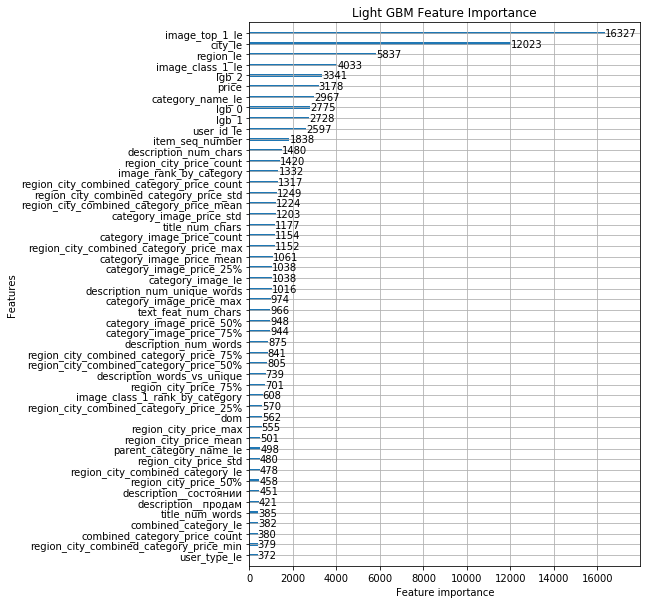

In [92]:
params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'regression'
best_lgb_params["metric"] = 'rmse'
best_lgb_params['learning_rate'] = 0.019 # Smaller learning rate

best_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_params['max_depth'] = int(params['max_depth'])    
best_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = params['feature_fraction']
best_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_params['bagging_freq'] = 1
best_lgb_params['lambda_l2'] = params['lambda_l2']
best_lgb_params['lambda_l1'] = params['lambda_l1']

print (best_lgb_params)

# Variable names for Level 1 LightGBM models 
l1_lgb_vars = ['lgb_' + str(i) for i in range(n_models)]

# split train_blend_x_lgb in the same way as X_train, X_val were created.

blend_x_lgb_train, blend_x_lgb_val, _, _ = train_test_split(
    train_blend_x_lgb, y, test_size=0.10, random_state=23)

# Cominbe level models' outputs with original data
lgtrain = lgb.Dataset(csr_matrix(hstack([X_train, blend_x_lgb_train])), y_train,
                feature_name=full_vars + l1_lgb_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False)
lgvalid = lgb.Dataset(csr_matrix(hstack([X_valid, blend_x_lgb_val])), y_valid,
                feature_name=full_vars + l1_lgb_vars,
                categorical_feature = dense_cat_vars,free_raw_data=False )

l2_lgb_model = lgb.train(
    best_lgb_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(l2_lgb_model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, l2_lgb_model.predict(X_valid))))



modelstart = time.time()
best_l2_lgb_iteration = int(l2_lgb_model.current_iteration()*1.05)

# l2_lgb_model = lgb.train(
#     best_lgb_params,
#     lgb.Dataset(csr_matrix(hstack([train_x, train_blend_x_lgb])), y,
#                 feature_name=full_vars,
#                 categorical_feature=dense_cat_vars),
#     num_boost_round=best_l2_lgb_iteration
# )


l2_lgb_model = lgb.train(
    best_lgb_params,
    lgb.Dataset(csr_matrix(hstack([train_x, train_blend_x_lgb])), y,
                feature_name=full_vars + ['blend_1', 'blend_2', 'blend_3'],
                categorical_feature=dense_cat_vars),
    num_boost_round=best_l2_lgb_iteration
)

lgbpred = l2_lgb_model.predict(csr_matrix(hstack([test_x, test_blend_x_lgb])))
lgbsub = pd.DataFrame(lgbpred, columns=["deal_probability"], index=test_index)
lgbsub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
lgbsub.to_csv("sub_l1_lgb_l2_lgb.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart)/60))


# del lgtrain, lgvalid
# gc.collect()